# Modbus readings analysis

This notebook loads the latest SQLite log by searching for an `outputs/` folder starting
from the notebook location (walking up parent directories), then provides
basic plots plus anomaly detection helpers.

Dependencies:
- pandas
- numpy (installed with pandas)
- matplotlib
- (optional) statsmodels for STL-based residual z-scores

Set `DB_PATH` in the first code cell to analyze a specific database file.


In [270]:
from pathlib import Path
import sqlite3
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = None  # set to Path("outputs/modbus_readings_YYYY-MM-DD_HH-mm-ss.sqlite")
def find_outputs_dir(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        outputs_dir = candidate / "outputs"
        if outputs_dir.is_dir():
            return outputs_dir
    return start / "outputs"

OUTPUTS_DIR = find_outputs_dir(Path.cwd())

def latest_db_path(outputs_dir: Path) -> Path:
    candidates = sorted(
        outputs_dir.glob("modbus_readings_*.sqlite"),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )
    if not candidates:
        raise FileNotFoundError(
            f"No modbus_readings_*.sqlite files found in {outputs_dir}"
        )
    return candidates[0]

db_path = Path(DB_PATH) if DB_PATH else latest_db_path(OUTPUTS_DIR)
print(f"Using DB: {db_path}")


Using DB: /home/andreu/Escritorio/GitHub/PersonalProjects/py-modbus-web-monitor/outputs/modbus_readings_2026-01-10_14-18-11.sqlite


In [271]:
def load_readings(db_path: Path, limit=None) -> pd.DataFrame:
    query = (
        """
        SELECT timestamp, source, host, port, unit_id, kind, address, value, label
        FROM readings
        ORDER BY timestamp
        """
    )
    params = None
    if limit is not None:
        query = f"{query} LIMIT ?"
        params = (limit,)
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(query, conn, params=params)
    if df.empty:
        return df
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

df = load_readings(db_path)
df.head()


,timestamp,source,host,port,unit_id,kind,address,value,label
0,2026-01-10 13:18:11.139381+00:00,monitor,127.0.0.1,1502,1,holding,0,798.0,Register 0
1,2026-01-10 13:18:12.151649+00:00,monitor,127.0.0.1,1502,1,holding,0,730.0,Register 0
2,2026-01-10 13:18:13.164458+00:00,monitor,127.0.0.1,1502,1,holding,0,623.0,Register 0
3,2026-01-10 13:18:14.172395+00:00,monitor,127.0.0.1,1502,1,holding,0,535.0,Register 0
4,2026-01-10 13:18:15.178913+00:00,monitor,127.0.0.1,1502,1,holding,0,423.0,Register 0


In [272]:
series_cols = ["host", "port", "unit_id", "kind", "address", "label"]
series = (
    df[series_cols]
    .drop_duplicates()
    .sort_values(series_cols)
    .reset_index(drop=True)
)
series.head(20)


,host,port,unit_id,kind,address,label
0,127.0.0.1,1502,1,holding,0,Register 0


In [273]:
SERIES = {}  # e.g. {"host": "127.0.0.1", "port": 502, "unit_id": 1, "kind": "holding", "address": 0, "label": None}

if df.empty:
    raise ValueError("No readings found. Check DB path or run the monitor to log data.")

if SERIES:
    series_key = SERIES
else:
    last_row = df.iloc[-1]
    series_key = {col: last_row[col] for col in series_cols}

series_key


{'host': '127.0.0.1',
 'port': np.int64(1502),
 'unit_id': np.int64(1),
 'kind': 'holding',
 'address': np.int64(0),
 'label': 'Register 0'}

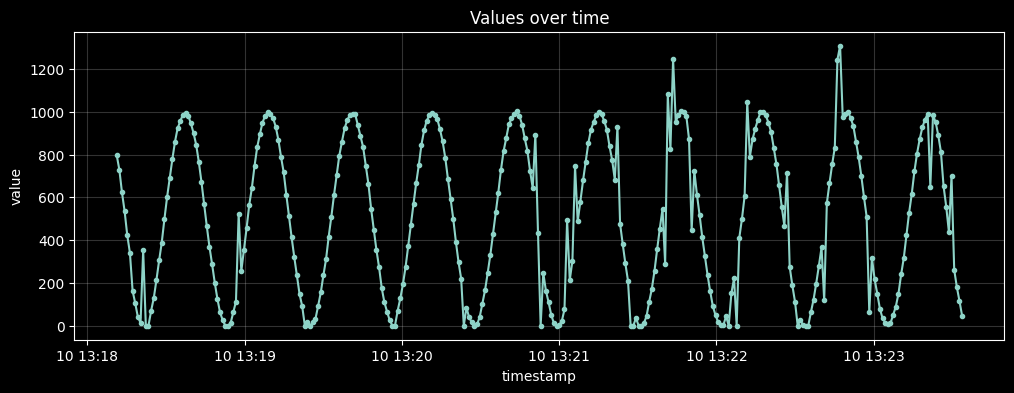

In [274]:
def select_series(df: pd.DataFrame, series_key: dict) -> pd.DataFrame:
    mask = pd.Series(True, index=df.index)
    for col, value in series_key.items():
        mask &= df[col] == value
    return df.loc[mask].copy()

series_df = select_series(df, series_key)
series_df.head()

plt.figure(figsize=(12, 4))
plt.plot(series_df["timestamp"], series_df["value"], marker=".", linestyle="-")
plt.title("Values over time")
plt.xlabel("timestamp")
plt.ylabel("value")
plt.grid(True, alpha=0.2)
plt.show()


In [275]:
dt = series_df["timestamp"].diff().dt.total_seconds().dropna()
if not dt.empty:
    print(f"Median dt: {dt.median():.3f}s")

values = series_df["value"].astype(float).tolist()
if len(values) < 4:
    print("Not enough samples to estimate period.")
else:
    def autocorr(vals, lag):
        size = len(vals) - lag
        if size <= 1:
            return 0.0
        mean = sum(vals) / len(vals)
        denom = sum((v - mean) ** 2 for v in vals)
        if denom == 0:
            return 0.0
        num = sum((vals[i] - mean) * (vals[i + lag] - mean) for i in range(size))
        return num / denom

    max_lag = max(2, min(100, len(values) - 2))
    min_lag = 2
    corr_by_lag = []
    for lag in range(min_lag, max_lag + 1):
        corr_by_lag.append((lag, autocorr(values, lag)))
    corr_by_lag.sort(key=lambda item: item[1], reverse=True)
    best_lag, best_corr = corr_by_lag[0]
    period = max(2, best_lag)
    suggested_window = max(3 * period, 30)
    suggested_min_samples = max(2 * period, 10)
    print(f"Estimated period: {period} samples (corr={best_corr:.3f})")
    print(f"Suggested WINDOW: {suggested_window}")
    print(f"Suggested MIN_SAMPLES: {suggested_min_samples}")
    print("Top lags:", corr_by_lag[:5])


Median dt: 1.010s
Estimated period: 2 samples (corr=0.856)
Suggested WINDOW: 30
Suggested MIN_SAMPLES: 10
Top lags: [(2, 0.8561997731482741), (31, 0.8471328230228009), (32, 0.8367919578066715), (30, 0.8367761375119256), (33, 0.7897596769573765)]


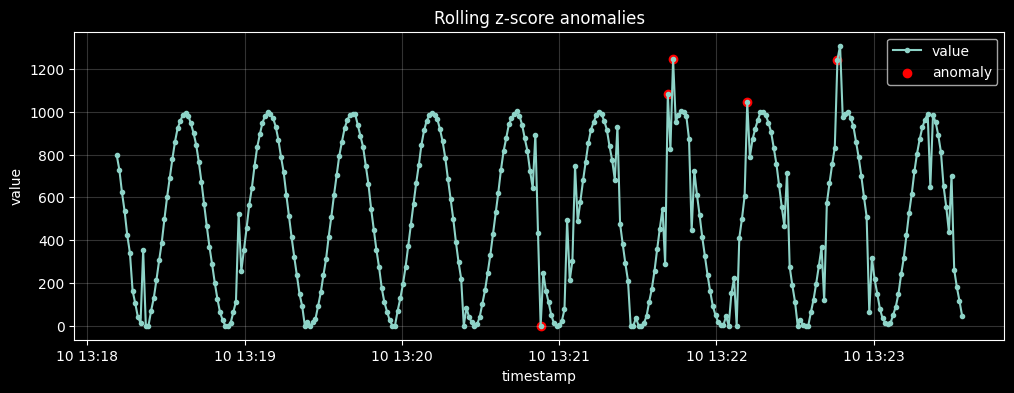

In [276]:
WINDOW = 20
MIN_SAMPLES = 15
THRESHOLD = 3.0

values = series_df["value"].astype(float)
rolling_mean = values.rolling(window=WINDOW, min_periods=MIN_SAMPLES).mean().shift(1)
rolling_std = values.rolling(window=WINDOW, min_periods=MIN_SAMPLES).std(ddof=1).shift(1)
z_scores = (values - rolling_mean) / rolling_std
z_scores = z_scores.replace([float("inf"), float("-inf")], np.nan)

series_df = series_df.assign(z_score=z_scores)
anomalies = series_df.loc[series_df["z_score"].abs() >= THRESHOLD]

anomalies.head()

plt.figure(figsize=(12, 4))
plt.plot(series_df["timestamp"], series_df["value"], marker=".", linestyle="-", label="value")
plt.scatter(anomalies["timestamp"], anomalies["value"], color="red", label="anomaly")
plt.title("Rolling z-score anomalies")
plt.xlabel("timestamp")
plt.ylabel("value")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


## Optional: STL residual z-score

STL works best with evenly spaced data and a known seasonal period. Adjust
`PERIOD` to match your sampling cadence.


                           timestamp   source       host  port  unit_id  \
131 2026-01-10 13:20:23.604312+00:00  monitor  127.0.0.1  1502        1   
158 2026-01-10 13:20:50.913508+00:00  monitor  127.0.0.1  1502        1   
160 2026-01-10 13:20:52.931297+00:00  monitor  127.0.0.1  1502        1   
170 2026-01-10 13:21:03.033162+00:00  monitor  127.0.0.1  1502        1   
173 2026-01-10 13:21:06.063132+00:00  monitor  127.0.0.1  1502        1   

        kind  address  value       label   z_score  
131  holding        0    0.0  Register 0 -2.932995  
158  holding        0  893.0  Register 0  0.705530  
160  holding        0    0.0  Register 0 -3.118473  
170  holding        0  493.0  Register 0  0.105182  
173  holding        0  745.0  Register 0  1.139561  


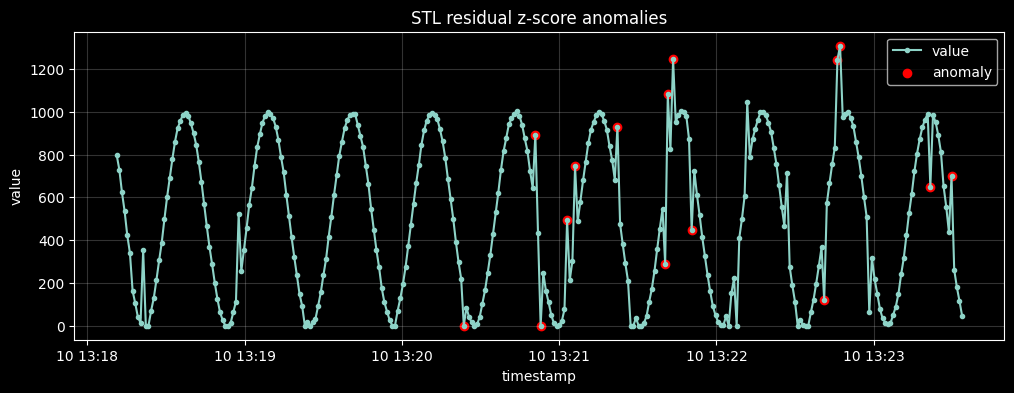

In [277]:
try:
    from statsmodels.tsa.seasonal import STL
except ImportError:
    print("statsmodels is not installed; skipping STL example.")
else:
    WINDOW = 90
    MIN_SAMPLES = 60
    PERIOD = 3
    stl = STL(series_df["value"].astype(float), period=PERIOD, robust=True)
    result = stl.fit()
    resid = result.resid
    resid_mean = resid.rolling(window=WINDOW, min_periods=MIN_SAMPLES).mean().shift(1)
    resid_std = resid.rolling(window=WINDOW, min_periods=MIN_SAMPLES).std(ddof=1).shift(1)
    resid_z = (resid - resid_mean) / resid_std
    resid_z = resid_z.replace([float("inf"), float("-inf")], np.nan)
    stl_anomalies = series_df.loc[resid_z.abs() >= THRESHOLD]
    print(stl_anomalies.head())

    plt.figure(figsize=(12, 4))
    plt.plot(series_df["timestamp"], series_df["value"], marker=".", linestyle="-", label="value")
    plt.scatter(stl_anomalies["timestamp"], stl_anomalies["value"], color="red", label="anomaly")
    plt.title("STL residual z-score anomalies")
    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
